Test function minimum at: [1.99999981 1.99999981]


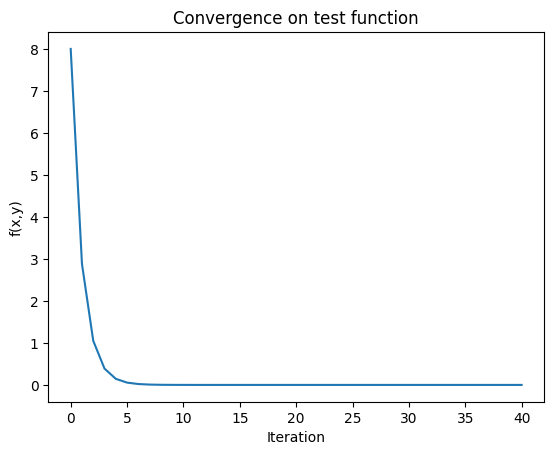

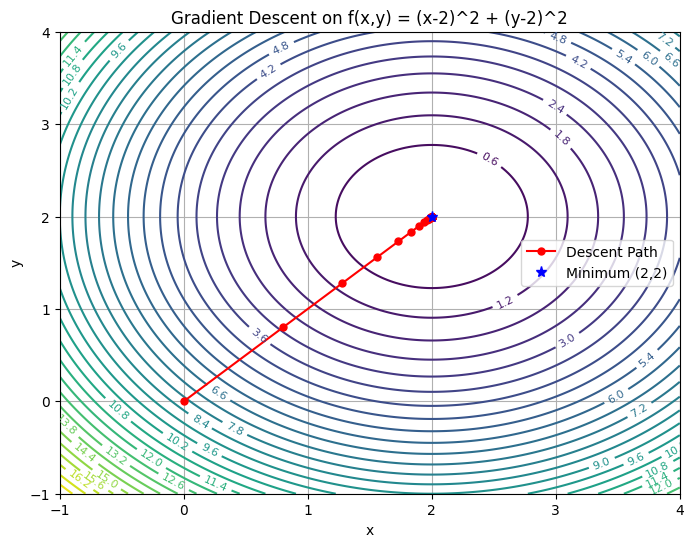

Best-fit (log10 phi*, log10 M*, alpha): [-2.56821552 10.97622653 -1.00939027]
Best-fit physical parameters:
phi* = 0.0027026168732999433
M*   = 94673085535.06577
alpha= -1.0093902656962668


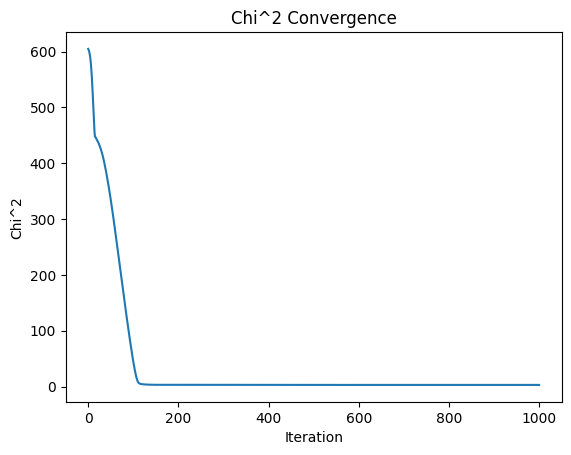

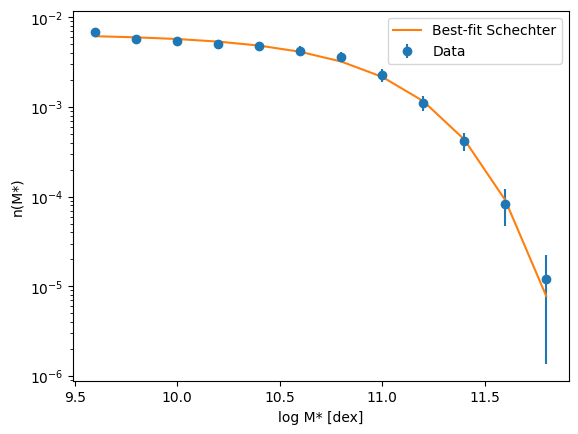

In [25]:
import numpy as np
import matplotlib.pyplot as plt


def numerical_gradient(f, params, h=1e-5):
    grad = np.zeros_like(params)
    for i in range(len(params)):
        step = np.zeros_like(params)
        step[i] = h
        grad[i] = (f(params + step) - f(params - step)) / (2*h)
    return grad


def gradient_descent(f, init_params, lr=0.1, tol=1e-6, max_iter=500,
                     grad_clip=10, decay=0.99):

    params = np.array(init_params, dtype=float)
    history = [params.copy()]
    values = [f(params)]
    current_lr = lr

    for i in range(max_iter):
        grad = numerical_gradient(f, params)

        # Clip gradients to avoid explosion
        grad_norm = np.linalg.norm(grad)
        if grad_norm > grad_clip:
            grad = grad * (grad_clip / grad_norm)

        params -= current_lr * grad

        history.append(params.copy())
        values.append(f(params))

        if grad_norm < tol:
            break

        # Decay learning rate
        current_lr *= decay

    return params, np.array(history), np.array(values)


def test_function(p):
    x, y = p
    return (x - 2)**2 + (y - 2)**2

# Run gradient descent on test function
best_params, path, hist = gradient_descent(test_function, init_params=[0,0], lr=0.2)
print("Test function minimum at:", best_params)

plt.plot(hist)
plt.xlabel("Iteration")
plt.ylabel("f(x,y)")
plt.title("Convergence on test function")
plt.show()

x = np.linspace(-1, 4, 200)
y = np.linspace(-1, 4, 200)
X, Y = np.meshgrid(x, y)
Z = (X - 2)**2 + (Y - 2)**2

plt.figure(figsize=(8, 6))
contours = plt.contour(X, Y, Z, levels=30, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)

# Plot descent path
plt.plot(path[:,0], path[:,1], 'ro-', label='Descent Path', markersize=5)
plt.plot(2, 2, 'b*', markersize=8, label='Minimum (2,2)')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient Descent on f(x,y) = (x-2)^2 + (y-2)^2')
plt.legend()
plt.grid(True)
plt.show()


# Schechter function and chi^2
def schechter(logM, phi_star, M_star, alpha):
    M = 10**logM
    return (phi_star * (M/M_star)**(alpha+1) *
            np.exp(-M/M_star) * np.log(10))

def chi2(params, logM, n_obs, err):
    log_phi, log_Mstar, alpha = params
    phi_star = 10**log_phi
    M_star = 10**log_Mstar
    model = schechter(logM, phi_star, M_star, alpha)
    return np.sum(((n_obs - model)/err)**2)


logM, n_obs, err = np.loadtxt("smf_cosmos.dat", unpack=True)

f = lambda p: chi2(p, logM, n_obs, err)

init_params = [np.log10(1e-2), np.log10(1e9), -2.0]

best_fit, path_fit, chi2_hist = gradient_descent(f, init_params,
                                                 lr=0.02, max_iter=1000,
                                                 grad_clip=2, decay=0.99)

print("Best-fit (log10 phi*, log10 M*, alpha):", best_fit)

phi_star_fit = 10**best_fit[0]
M_star_fit = 10**best_fit[1]
alpha_fit = best_fit[2]
print("Best-fit physical parameters:")
print("phi* =", phi_star_fit)
print("M*   =", M_star_fit)
print("alpha=", alpha_fit)


# Plot chi^2 vs iteration
plt.plot(chi2_hist)
plt.xlabel("Iteration")
plt.ylabel("Chi^2")
plt.title("Chi^2 Convergence")
plt.show()

# Plot best-fit Schechter vs data
plt.errorbar(logM, n_obs, yerr=err, fmt='o', label="Data")
plt.plot(logM, schechter(logM, phi_star_fit, M_star_fit, alpha_fit),
         label="Best-fit Schechter")
plt.yscale("log")
plt.xlabel("log M* [dex]")
plt.ylabel("n(M*)")
plt.legend()
plt.show()
